# FargoCPT Dust

This notebook shows how to setup a simulation with dust and visualize the results.

First we create a new directory and change to it.

In [1]:
example_name = "402_Dust"
example_dir = f"example_dirs/{example_name}"
import os
if not os.path.basename(os.getcwd()) == example_name:
    repo_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
    !mkdir -p $example_dir
    os.chdir(example_dir)
print(f"Current working directory: {os.getcwd()}")
print(f"Repository root directory: {repo_root}")

Current working directory: /home/rometsch/repo/fargocpt/examples/example_dirs/402_Dust
Repository root directory: /home/rometsch/repo/fargocpt


## Make sure the code is built by running make again.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C $repo_root/src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

2.85 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp $repo_root/examples/config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [5]:
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 20 # write a snapshot every orbit
config["Nsnapshots"] = 10 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps

config["cps"] = 4

config["IntegrateParticles"] = "yes"
config["NumberOfParticles"] = 10_000
# only use one particle species, this helps better resolve the disk
config["ParticleSpeciesNumber"] = 2
config["ParticleRadiusIncreaseFactor"] = 1e-3


with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Run the simulation

This will take a while. Unfortuantely, we need quite a number of particles to get reasonable plots.

Keep in mind that we need a high enough number of particles to resolve the dynamics of the disk.

In [25]:
from fargocpt import run
run(["start", configfile], np=2, nt=8, exe=repo_root+"/bin/fargocpt_exe", detach=False)

/home/rometsch/repo/fargocpt/bin/fargocpt_exe
Running command: mpirun -np 2 --report-pid /tmp/tmpyx_hpwyd --map-by ppr:1:numa --bind-to numa -x OMP_WAIT_POLICY=active -x OMP_PROC_BIND=close -x OMP_PLACES=cores -x OMP_NUM_THREADS=8 /home/rometsch/repo/fargocpt/bin/fargocpt_exe start setup.yml
fargo process pid 1214343

[0] MPI rank #  0 runs as process 1214346
[1] MPI rank #  1 runs as process 1214347
[1] MPI rank #  1 OpenMP thread #  0 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  0 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  1 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  5 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  3 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  2 of  8 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  1 of  8 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  3 of  8 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  7 of  8 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  5 of  8 on cpt-kamino
[0] MPI rank #  0 OpenMP t

0

Now, there is an additional `particles.dat` file in each snapshot directory.

In [7]:
print(os.listdir(config["OutputDir"] + "/snapshots/1"))

['rebound.bin', 'Sigma.dat', 'energy.dat', 'vrad.dat', 'misc.bin', 'vazi1D.dat', 'particles.dat', 'vrad1D.dat', 'nbody0.bin', 'nbody1.bin', 'Sigma1D.dat', 'vazi.dat', 'config.yml', 'energy1D.dat']


In [8]:
from fargocpt import Loader

In [9]:
l = Loader("output/out")
print(l)
print(l.particles)

   Loader
| output_dir: output/out
| snapshots: 0 ... 10
| special_snapshots: ['reference']
| snapshot_time: 0.0 5.02257e+06 s ... 62.8 5.02257e+06 s
| monitor_number: 0 ... 200
| units: Units
| target_units = None
| gas: Hydro
| nbody: Nbody
| params: Params
| particles: Particles
____________________

   Particles
| output_dir: output/out
| target_units= None
| var_names:
|   id
|   r
|   phi
|   r_dot
|   phi_dot
|   r_ddot
|   phi_ddot
|   mass
|   size
|   timestep
|   facold
|   stokes
|   x
|   y
____________________



Let's visualize the last snapshot.

In [10]:
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt

def plot_field(loader, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis", title=None):
    R, PHI, vals = loader.gas.vars2D.get(name, N, grid_for_plot=True)
    if dataunit is None:
        dataunit = vals.unit
    Z = vals.to_value(dataunit)

    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = loader.snapshot_time[N].to_value("kyr")
    if title is None:
        title = ""
    else:
        title += "\n"
    title += f" t={t:.2e}kyr, N={N}"
    ax.set_title(title)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

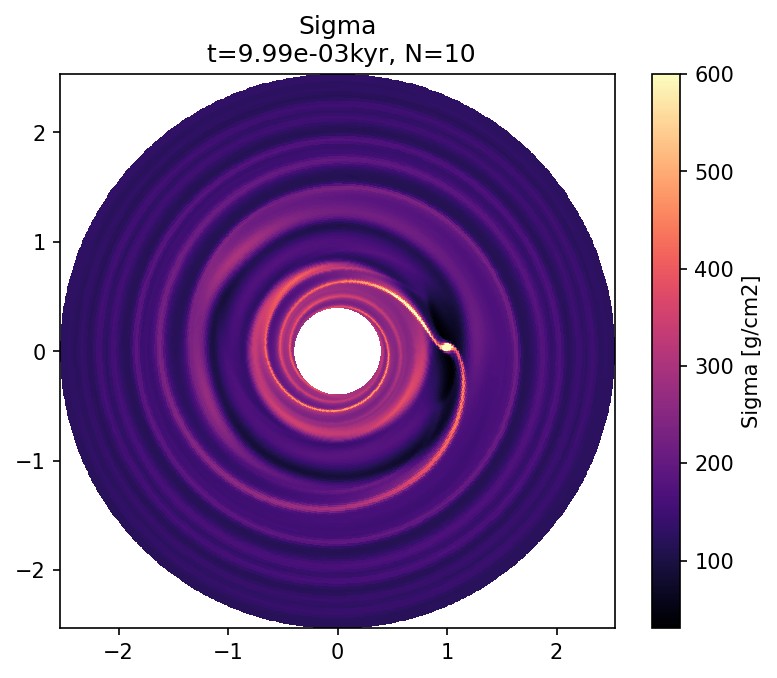

In [11]:
Nlast = l.snapshots[-1]
plot_field(l, "Sigma", 10, dataunit="g/cm2", cmap="magma", title="Sigma", vmax=600);

To visualize the particles at the same snapshot:

Text(0, 0.5, 'y [au]')

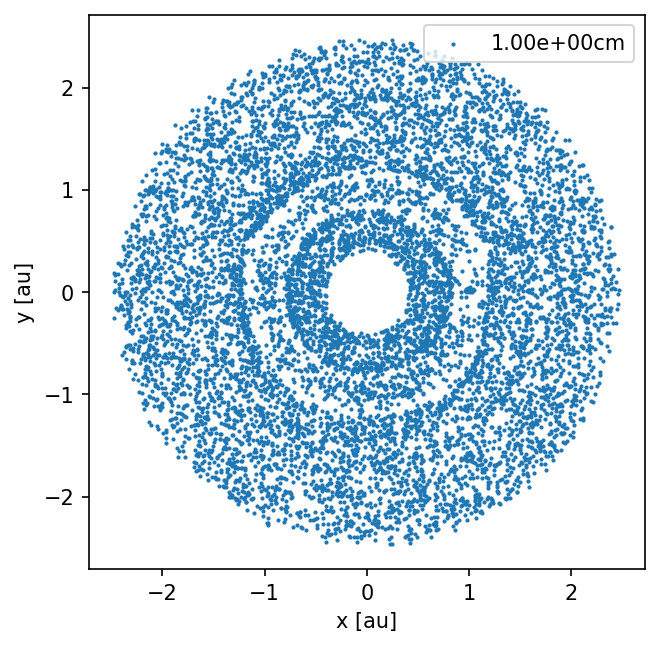

In [12]:
# load dust coordinates into local variables
xs = l.particles.get("x", Nlast)
ys = l.particles.get("y", Nlast)
rs = l.particles.get("r", Nlast)
phis = l.particles.get("phi", Nlast).to_value("rad")

# get the unique sizes and sort the particles by size
size = l.particles.get("size", Nlast).to("cm")
unique_sizes = np.unique(size)
unique_sizes

inds_size = {s : np.where(size==s) for s in unique_sizes}

dust = {}
for nd, s in enumerate(unique_sizes):
    dust[nd] = {}
    dust[nd]["x"] = xs[inds_size[s]]
    dust[nd]["y"] = ys[inds_size[s]]
    dust[nd]["r"] = rs[inds_size[s]]
    dust[nd]["phi"] = phis[inds_size[s]]
    dust[nd]["size"] = s


fig, ax = plt.subplots(dpi=150)
for nd, val in dust.items():
    s = val["size"]
    ax.scatter(val["x"], val["y"],label=f"{s.to_value('cm'):.2e}cm", s=1)
ax.legend()

# ax.scatter(x, y, s=1)
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

There is something like a gap carved by the planet visible.
But it's hard to tell the surface density at from the clumping of points.

So as a next step, let's convert the particles to a surface density.

For this, we'll use a small python package which bins the particles into the hydro grid.

In [13]:
!pip install git+https://github.com/rometsch/coords2sigma

  Cloning https://github.com/rometsch/coords2sigma to /tmp/pip-req-build-i5all4bc
  Running command git clone --filter=blob:none --quiet https://github.com/rometsch/coords2sigma /tmp/pip-req-build-i5all4bc
  Resolved https://github.com/rometsch/coords2sigma to commit 06f5edbdbad6e1610133b1974d4e578763e1d327
  Installing build dependencies ... 

done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
import coords2sigma

In [15]:
coords2sigma.surface_density_from_distribution?

Signature:
coords2sigma.surface_density_from_distribution(
    q1_coords,
    q2_coords,
    q1_grid_i,
    q2_grid_i,
    weights=None,
    polar=False,
)
Docstring:
Convert particle coordinates to a surface density field.

Individuals masses of particles can be specified by passing them as the weights parameter.
You'll need to rescale appropriately.

Args:
    q1_coords (array): Particle coordinates in first dimension.
    q2_coords (array): Particle coordinates in second dimension.
    q1_grid_i (array): Interface locations in first dimension of the desired grid.
    q2_grid_i (array): Interface locations in second dimension of the desired grid.
    weights (array of same shape as coords): Wheights for the masses of particles.
    polar (bool): Whether or not it is a polar grid.
    
Returns:
    2d array of shape = (len(q1_grid_i), len(q2_grid_i)): surface density of the particle distribution
    
Raises:
    ValueError: if grid coordinates are non monotonic or different than linea

### Coarser grid

The grid of the hydro simulation is too fine for the number of particles.
Thus, resample the grid to a coarser resolution.

First, get the hydro simulation grid.

In [16]:
l.gas.grid

   Grid
| radi: 0.39501060761975204 1.49598e+13 cm ... 2.5315775847787663 1.49598e+13 cm
| phii: 0.0 ... 6.283185307179586
| Nrad: 148
| Naz: 504
| Spacing: Logarithmic
____________________

In [17]:
r_g_i = l.gas.grid.radi.to("au")
phi_g_i = l.gas.grid.phii

R_g_i_au, PHI_g_i_rad = np.meshgrid(r_g_i.to_value("au"), phi_g_i, indexing="ij")
X_g_i_au = R_g_i_au*np.cos(PHI_g_i_rad)
Y_g_i_au = R_g_i_au*np.sin(PHI_g_i_rad)

r_g_i_au = r_g_i.to_value("au")
r_g_c_au = 0.5*(r_g_i_au[:-1] + r_g_i_au[1:])

Now resample the grid using the library.
The number of azimuthal cells will be chosen such that the cells have an aspect ratio of unity.

In [18]:
coords2sigma.resample_grid?

Signature: coords2sigma.resample_grid(q1_i, q2_i, N, N_2=None, polar=False)
Docstring:
Resample the coordinates of a regular grid.

The grid is resampled to have squared cells if N_2 is not defined.
Supported are linarly spaced and logarithmically spaced coordinates.

For polar grids with linear radial spacing, the parameter N_2 has to be defined.

Args:
    q1_i (np.array(double)): Interface coordinates in first direction.
    q2_i (np.array(double)): Interface coordinates in first direction.
    N (int): Number of grid cells in first direction.
    N_2 (int, optional): Number of grid cells in first direction.
    polar (bool): Specify whether it is a squred grid.

Returns:
    (new_q1, new_q2) (np.array(double), np.array(double)): New corrdinate arrays.

Raises:
    ValueError: For a polar grid with linear radial spacing, if N_2 is not defined.
File:      ~/repo/fargocpt/python-venv/lib/python3.10/site-packages/coords2sigma.py
Type:      function

In [19]:
Nr = 64
import astropy.units as u
r_i, phi_i = coords2sigma.resample_grid(r_g_i.to_value("cm"), phi_g_i, N=Nr, polar=True)
r_i = r_i * u.cm
phi_i = phi_i

Inspect old and new grid shape

In [20]:
print("Old", r_g_i.shape, phi_g_i.shape)
print("New", r_i.shape, phi_i.shape)

Old (149,) (505,)
New (64,) (213,)


### Convert particle distribution to surface densities

In [21]:

sigmads = {}
for nd, d in dust.items():
    sd = coords2sigma.surface_density_from_distribution(
        d["r"].to_value("au"),
        d["phi"], 
        r_i.to_value("au"), 
        phi_i, 
        polar=True)
    d["sigma"] = sd

Construct new meshgrid for subsampled grid.

In [22]:
r_i_au = r_i.to_value("au")
phi_i_rad = phi_i
R_i_au, PHI_i_rad = np.meshgrid(r_i_au, phi_i_rad, indexing="ij")
X_i_au = R_i_au*np.cos(PHI_i_rad)
Y_i_au = R_i_au*np.sin(PHI_i_rad)

Compare the field to a scatter plot.

(-2.5315775847787667, 2.5315775847787667)

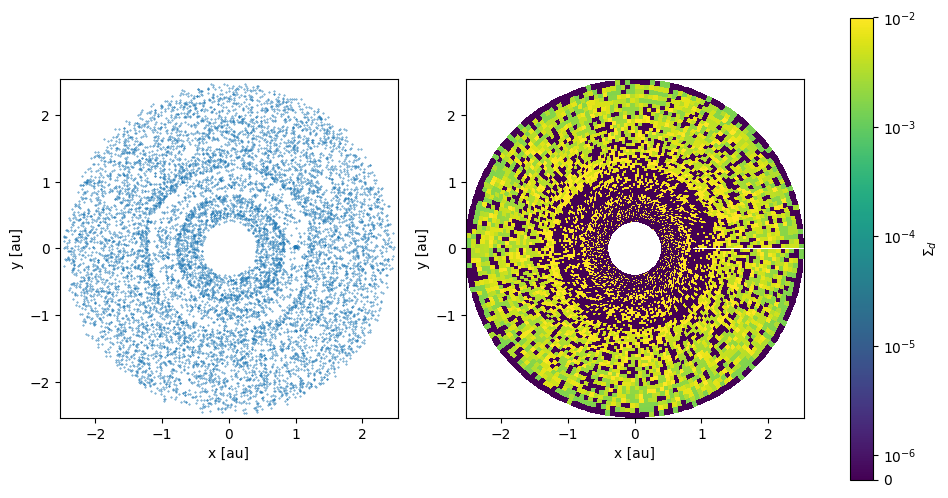

In [23]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

nd = 0
rd = dust[nd]["r"].to_value("au")
phid = dust[nd]["phi"]
Xd = rd*np.cos(phid)
Yd = rd*np.sin(phid)
ax = axs[0]
ax.scatter(Xd, Yd, marker=".", s=0.5)
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

ax = axs[1]
Z = dust[nd]["sigma"]/np.max(dust[nd]["sigma"])
norm = mplcolors.SymLogNorm(linthresh=1e-6, linscale=0.2, vmin=0, vmax=1e-2)
pcm = ax.pcolormesh(X_i_au, Y_i_au, Z, norm=norm)
cax = fig.colorbar(pcm, ax=axs)
cax.set_label(r"$\Sigma_d$")
ax.set_aspect("equal")
ax.set_xlabel("x [au]")
ax.set_ylabel("y [au]")

axs[0].set_ylim(axs[1].get_ylim())
axs[0].set_xlim(axs[1].get_xlim())

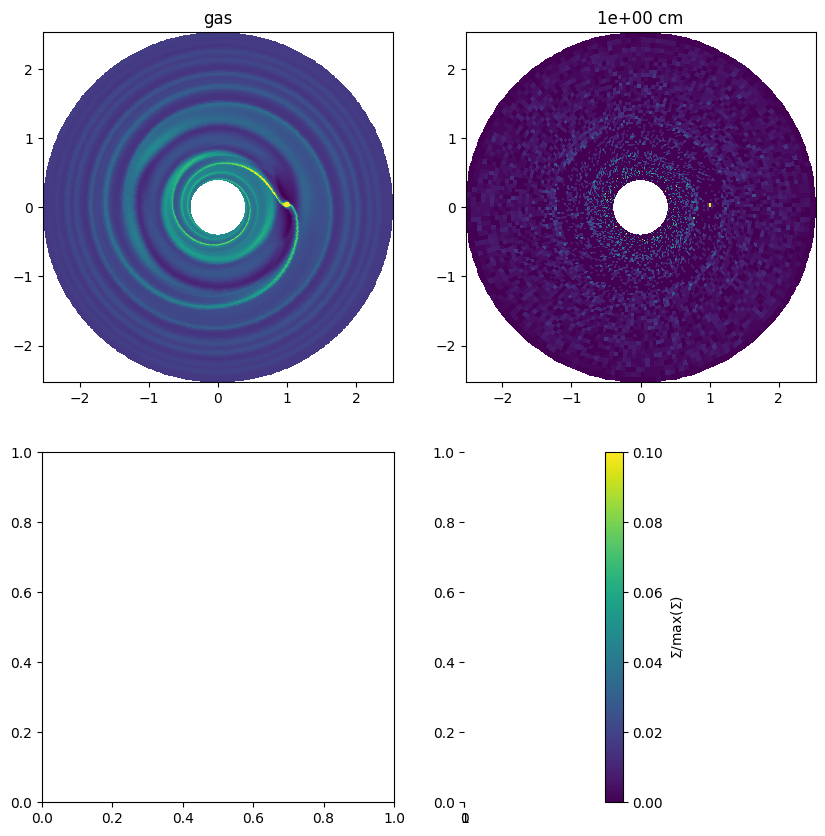

In [24]:

mplcolors.Normalize(vmin=0, vmax=1)

#
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
# make the axes array flat
axs = axs.ravel()

#
# Plot gas
#

N = l.snapshots[-1]
# get the values
Z = l.gas.vars2D.get("Sigma", N, grid=False).to_value("g/cm2")

# make a colormesh plot
pcm = axs[0].pcolormesh(X_g_i_au, Y_g_i_au, Z, rasterized=True, vmax=600)

# decorate
axs[0].set_aspect("equal")
axs[0].set_title("gas")


#
# Plot dust
#

# mask for outer disk for the dust surface densities
r_c_au = 0.5*(r_i_au[:-1] + r_i_au[1:])
inds_outer = r_c_au > 40

dust_vmax = 0.1

for nd, ax in zip(dust, axs[1:]):     
    # get values
    Z = d["sigma"]
    Z = Z / np.max(Z)
    
    # make a colormesh plot
    pcm = ax.pcolormesh(X_i_au, Y_i_au, Z, vmax=dust_vmax, rasterized=True)
    
    # decorate
    ax.set_aspect("equal")
    size = dust[nd]["size"]
    ax.set_title(f"{size:.0e}")

#
# Add a colorbar in the bottom right corner
#
cax = fig.colorbar(pcm, ax=axs[-1], pad=0.4, fraction=0.6, location="right")
cax.set_label(r"$\Sigma/\mathrm{max}(\Sigma)$")

#
# Decoration
#

# Turn off original axes in the bottom right corner
axs[-1].set_frame_on(False)